# Numerical methods

In [ ]:
import numpy as np
from numpy.linalg import solve, norm, cond, cholesky
from functools import partial

In [ ]:
def get_relative_error(original_vector, other_vector):
    
    return norm(original_vector - other_vector, np.inf) / norm(original_vector)


def get_absolute_error(original_vector, other_vector):
    
    return norm(original_vector - other_vector, np.inf)


## Task 1

### Description

For given system of equations $Ax = b$ Investigate the dependence of the error $x$ on errors of the right side of the system $b$.

### Solution

In [ ]:
class Task1:

    @staticmethod
    def build_matrix():
        n = 7
        
        def get_matrix_element(i, j):
            variant = 5
            c = 0.1 * variant * i * j
            
            element = 135 / (2 + 0.3 * c) ** 5
            
            return element
        
        def build_matrix_row(row_num):
            get_row_element = partial(get_matrix_element, row_num)
            
            return list(map(get_row_element, range(1, n + 1)))
        
        return np.array(list(map(build_matrix_row, range(1, n + 1))))
    
    @staticmethod
    def build_result_vector():
        return np.array([5.0] * 7)
    
    @staticmethod
    def get_vectors_with_component_delta(result_vector):
        delta = 10e-3
        
        def add_delta_to_position(vector, position):
            new_vector = vector.copy()
            new_vector[position] += delta
            return new_vector
        
        return np.array(list(map(partial(add_delta_to_position, result_vector), range(len(result_vector)))))
    


#### Finding numerical solution

In [ ]:
matrix = Task1.build_matrix()
result_vector = Task1.build_result_vector()


In [ ]:
gauss_solution = solve(matrix, result_vector)
print("Solution of our equation with Gauss method:", list(map(lambda x: "{:.5}".format(x), gauss_solution)))


('Solution of our equation with Gauss method:', ['158.78', '-4313.6', '4.2377e+04', '-1.8833e+05', '4.106e+05', '-4.2745e+05', '1.6943e+05'])


Now we compare $b_*$ with $b$, where $Ax_* = b_*$

In [ ]:
np.allclose(np.dot(matrix, gauss_solution), result_vector)

True

$b \simeq b_*$. Therefore we can say that $x_*$ is correct numerical solution

#### Finding condition number of $A$

In [ ]:
condition_number = cond(matrix)
print("Condition number of matrix:", condition_number)

('Condition number of matrix:', 150414531.0558092)


As we can observe matrix $A$ is extremely poorly conditioned

#### Investigating error dependence

In [ ]:
vectors_with_delta_components = Task1.get_vectors_with_component_delta(result_vector)
solutions_delta = list(map(partial(np.linalg.solve, matrix), vectors_with_delta_components))

In [ ]:
relative_errors = list(map(partial(get_relative_error, gauss_solution), solutions_delta))

print("Relative errors:")
for i, relative_difference in enumerate(relative_errors):
    print("{}: {:.2e}".format(i + 1, relative_difference))


Relative errors:
1: 3.42e-05
2: 1.38e-03
3: 1.61e-02
4: 7.86e-02
5: 1.82e-01
6: 1.98e-01
7: 8.07e-02


In [ ]:
print("Highest contribution to the error delivers b[{}] with value of relative error = ~{:.5}"
      .format(np.argmax(relative_errors), np.max(relative_errors)))


Highest contribution to the error delivers b[5] with value of relative error = ~0.1975


In [ ]:
theoretical_error = condition_number * get_relative_error(result_vector, vectors_with_delta_components[5])

print("Theoretical error = {:.5}".format(theoretical_error))

Theoretical error = 1.137e+05


In [ ]:
print("Difference between theoretical error and practical error is {} >> 0".format(theoretical_error - np.max(relative_errors)))


Difference between theoretical error and practical error is 113702.500424 >> 0


As be can see from above practical error is much less than theoretical error due to high value of theoretical error.

The value of theoretical error directly depends on $cond(A)$ which is extremely high in our case.


## Task 2

### Description

Solve given system of equations $Ax = b$ with symmetric positive definite matrix $A$ with Cholesky method

### Solution

In [ ]:
class Task2:
    
    matrix_size = 20
    
    @staticmethod
    def build_matrix():
        n = float(Task2.matrix_size)
        m = 8.0
        
        def get_matrix_element(i, j):
            if i == j:
                return n + m ** 2 + j / m + i / n
            else:
                return (i + j) / (m + n)
            
        def build_matrix_row(row_num):
            get_row_element = partial(get_matrix_element, row_num)
            
            return list(map(get_row_element, range(1, Task2.matrix_size + 1)))
        
        return np.array(list(map(build_matrix_row, range(1, Task2.matrix_size + 1))))
    
    @staticmethod
    def build_result_vector():
        
        return np.array(list(map(lambda i: 200 + 50 * i, range(1, Task2.matrix_size + 1))))
    
    

In [ ]:
matrix = Task2.build_matrix()
result_vector = Task2.build_result_vector()


Get matrix $L$ from Cholesky decomposition $LL^T = A$

In [ ]:
decomposition_lower = cholesky(matrix)


Find $y$ from $Ly = b$

In [ ]:
cholesky_solution = solve(decomposition_lower, result_vector)

Find $x_*$ from $L^T x_* = y$

In [ ]:
solution = solve(decomposition_lower.transpose(), cholesky_solution)

print("Our solution:", list(map(lambda x: "{:.5}".format(x), solution)))

('Our solution:', ['2.1322', '2.6631', '3.1927', '3.721', '4.248', '4.7737', '5.2981', '5.8213', '6.3431', '6.8637', '7.3831', '7.9012', '8.418', '8.9335', '9.4478', '9.9609', '10.473', '10.983', '11.493', '12.001'])


Now we compare $b_*$ with $b$, where $Ax_* = b_*$

In [ ]:
np.allclose(np.dot(matrix, solution), result_vector)

True

$b \simeq b_*$. Therefore we can say that $x_*$ is correct numerical solution

## Task 3

### Description

For given system of equations $Ax = b$, where $A = A(t)$, investigate the dependence of the solution of $Ax = b$ on the computational error for given values of the parameter t.

### Solution

In [ ]:
class Task3:
    matrix_size = 50

    _m = 1
    _q_m = 0.993 + (-1) ** _m * _m * 1e-4

    @staticmethod
    def build_matrix(t):

        def get_matrix_element(i, j):
            if i == j:
                return Task3._q_m ** j + t
            else:
                return Task3._q_m ** j

        def build_matrix_row(row_num):
            get_row_element = partial(get_matrix_element, row_num)

            return list(map(get_row_element, range(1, Task3.matrix_size + 1)))

        return np.array(list(map(build_matrix_row, range(1, Task3.matrix_size + 1))))

    @staticmethod
    def build_result_vector():

        return np.array(list(map(lambda j: Task3._q_m ** (Task3.matrix_size + 1 - j), range(1, Task3.matrix_size + 1))))

    @staticmethod
    def solve_gauss_partial_selection(matrix, result_row):

        def replace(iter, place, new_element):
            new_iter = iter.copy()
            new_iter[place] = new_element
            return new_iter

        def eliminate(matrix, result_row):

            def get_max_value_row_id(_matrix, step_index):
                column = _matrix[step_index:, step_index]
                max_index = np.argmax(column) + step_index
                return max_index

            def eliminate_after_row(matrix, result_row, i, j):

                if i == len(matrix):
                    return matrix, result_row

                current_row = matrix[i]
                next_row = matrix[j]

                k = next_row[i] / current_row[i]
                updated_matrix_row = next_row - k * current_row

                updated_result_row_element = result_row[j] - k * result_row[i]

                new_matrix = replace(matrix, j, updated_matrix_row)
                new_result_row = replace(result_row, j, updated_result_row_element)

                if j == len(matrix) - 1:
                    return new_matrix, new_result_row
                else:
                    return eliminate_after_row(new_matrix, new_result_row, i, j + 1)

            new_matrix = matrix.copy()
            new_result_row = result_row.copy()
            for i in range(len(matrix) - 1):
                max_value_row_id = get_max_value_row_id(new_matrix, i)
                new_matrix[[i, max_value_row_id]] = new_matrix[[max_value_row_id, i]]
                new_result_row[i], new_result_row[max_value_row_id] = new_result_row[max_value_row_id], new_result_row[
                    i]
                new_matrix, new_result_row = eliminate_after_row(new_matrix, new_result_row, i, i + 1)

            return new_matrix, new_result_row

        def back_substitute(matrix, result_row):

            def back_substitute_step(matrix, result_row, solution, i):
                if i < 0:
                    return solution

                new_solution = replace(solution, i, (result_row[i] - sum(matrix[i] * solution)) / matrix[i][i])
                return back_substitute_step(matrix, result_row, new_solution, i - 1)

            return back_substitute_step(matrix, result_row, np.zeros(len(result_row)), len(result_row) - 1)

        return back_substitute(*eliminate(matrix, result_row))

In [ ]:
t1 = 1e-4
t2 = 1
t3 = 1e4

In [ ]:
def get_solution_errors(t):
    matrix = Task3.build_matrix(t)
    result_vector = Task3.build_result_vector()
    
    solution = Task3.solve_gauss_partial_selection(matrix, result_vector)
    
    around_matrix = np.around(matrix, 6)
    around_result_vector = np.around(result_vector, 6)
    
    around_solution = Task3.solve_gauss_partial_selection(around_matrix, around_result_vector)
    
    return get_absolute_error(solution, around_solution), get_relative_error(solution, around_solution)



In [ ]:
errors = list(map(get_solution_errors, [t1, t2, t3]))

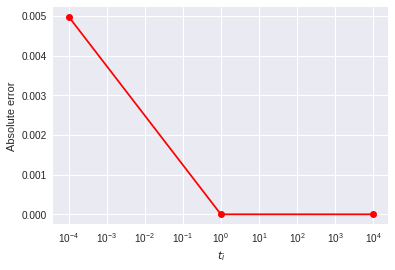

In [ ]:
from pylab import *
from operator import itemgetter

%matplotlib inline

plot([t1, t2, t3], list(map(itemgetter(0), errors)), 'ro-')

xlabel("$t_i$")
ylabel("Absolute error")
xscale('log')

As we can observe absolute error of rounded soultion is much more higher when $t$ has small value.

Exploration:  elements of $A$ grow lineary with growth of $t$. When $t$ is big enogh precision loss due to $around$ operation becomes insufficient.



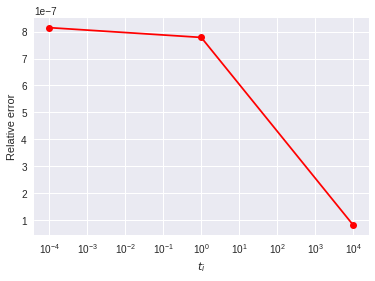

In [ ]:
plot([t1, t2, t3], list(map(itemgetter(1), errors)), 'ro-')

xlabel("$t_i$")
ylabel("Relative error")
xscale('log')

As we can observe, relative error lesses with growth of $t$. However, relative error remains small enogh.

Exploration: $relative\ error = \frac{absolute\ error}  {\parallel X \parallel}$ 

With growth of $t$ absolute error lessen and $\parallel X \parallel$ growth which leads to a strong fall of relative error